### libraries
- **NumPy** for numerical computations
- **TensorFlow** (specifically `to_categorical` and dataset loading)
- **scikit-learn** for `classification_report` and `accuracy_score` 
- **Matplotlib** for plotting, and **math** for `floor`.

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import math


### Activation Functions & Derivatives

Defines activation functions commonly used in neural networks:
- `sigmoid`: Computes $ \sigma(Z) = \frac{1}{1 + e^{-Z}} $.
- `relu`: Computes $ A = \max(0, Z) $.
- `softmax`: Computes probabilities for multiclass output, stabilized.
And their respective backward pass derivatives:
- `sigmoid_backward`: Derivative of sigmoid.
- `relu_backward`: Derivative of ReLU.
The `activation_cache` (which is $Z$) is returned for use in backpropagation.

In [10]:
def sigmoid(Z):
    """Computes the sigmoid activation."""
    A = 1 / (1 + np.exp(-Z))
    activation_cache = Z  # Cache Z for backpropagation
    return A, activation_cache


def relu(Z):
    """Computes the ReLU activation."""
    A = np.maximum(0, Z)
    activation_cache = Z
    return A, activation_cache


def softmax(Z):
    """Computes the softmax activation."""
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    activation_cache = Z
    return A, activation_cache


def sigmoid_backward(dA, activation_cache):
    """Computes the backward pass for sigmoid activation."""
    Z = activation_cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ


def relu_backward(dA, activation_cache):
    """Computes the backward pass for ReLU activation."""
    Z = activation_cache
    dZ = np.array(dA, copy=True)  # Create a copy to modify
    dZ[Z <= 0] = 0  # Gradient is 0 where Z <= 0
    return dZ

### Cost Function

`compute_multiclass_cost` calculates the **multiclass cross-entropy loss**. It uses `epsilon` clipping to prevent `log(0)` issues.
The cost is computed as $ J = -\frac{1}{m} \sum_{i=1}^{m} \sum_{c=1}^{N_c} y^{(i)}_c \log(a^{(i)}_c) $.

In [11]:
def compute_multiclass_cost(AL, Y_one_hot):
    """
    Computes the multiclass cross-entropy cost.
    AL: Post-activation predictions from the output layer (softmax), shape (num_classes, num_samples)
    Y_one_hot: True "label" vector, one-hot encoded, shape (num_classes, num_samples)
    """
    num_samples = Y_one_hot.shape[1]
    epsilon = 1e-12  # To prevent log(0)
    AL_clipped = np.clip(AL, epsilon, 1. - epsilon) 

    cost = - (1 / num_samples) * np.sum(np.multiply(Y_one_hot, np.log(AL_clipped)))
    cost = np.squeeze(cost) 
    assert (isinstance(cost, float))
    return cost

### Minibatch Creation

The `create_minibatches` utility shuffles the dataset (`X`, one-hot `Y`, and integer `Y` labels) and divides it into smaller, random mini-batches. This is crucial for efficient training with mini-batch gradient descent.



In [12]:
def create_minibatches(X_transposed, Y_one_hot_transposed, Y_int_labels, minibatch_size=128, seed=0):
    """
    Creates a list of random minibatches from (X, Y_one_hot, Y_int_labels).
    X_transposed: Input data, shape (num_features, num_samples)
    Y_one_hot_transposed: True labels (one-hot), shape (num_classes, num_samples)
    Y_int_labels: True labels (integer), shape (num_samples,)
    """
    np.random.seed(seed)
    num_samples = X_transposed.shape[1]
    minibatches = []

    permutation = list(np.random.permutation(num_samples))
    shuffled_X = X_transposed[:, permutation]
    shuffled_Y_one_hot = Y_one_hot_transposed[:, permutation]
    shuffled_Y_int = Y_int_labels[permutation]

    num_complete_minibatches = math.floor(num_samples / minibatch_size)
    for k in range(num_complete_minibatches):
        minibatch_X = shuffled_X[:, k * minibatch_size: (k + 1) * minibatch_size]
        minibatch_Y_one_hot = shuffled_Y_one_hot[:, k * minibatch_size: (k + 1) * minibatch_size]
        minibatch_Y_int = shuffled_Y_int[k * minibatch_size: (k + 1) * minibatch_size]
        minibatches.append((minibatch_X, minibatch_Y_one_hot, minibatch_Y_int))

    # Handling the end case (last minibatch may be smaller)
    if num_samples % minibatch_size != 0:
        minibatch_X = shuffled_X[:, num_complete_minibatches * minibatch_size:]
        minibatch_Y_one_hot = shuffled_Y_one_hot[:, num_complete_minibatches * minibatch_size:]
        minibatch_Y_int = shuffled_Y_int[num_complete_minibatches * minibatch_size:]
        minibatches.append((minibatch_X, minibatch_Y_one_hot, minibatch_Y_int))

    return minibatches


# Neural Network Class

The `NeuralNetwork` class encapsulates the entire deep learning model.
- **Initialization (`__init__`, `_initialize_parameters`):** Sets up layer dimensions, hidden layer activations (e.g., 'relu', 'sigmoid'), and initializes weights (He/Xavier) and biases. Optimizer states (for Momentum/Adam) are also prepared.
- **Forward Propagation (`_linear_forward_step`, `_linear_activation_forward_step`, `forward_propagation`):** Computes the network's output ($A^{[L]}$) by passing input $X$ through all layers, applying linear transformations and specified activations. Caches intermediate values for backpropagation.
- **Backward Propagation (`_linear_backward_step`, `_linear_activation_backward_step`, `backward_propagation`):** Calculates gradients of the cost function with respect to weights and biases for all layers, starting from the output layer and moving backward.
- **Parameter Update (`update_parameters`):** Modifies weights and biases using calculated gradients and a chosen optimizer (SGD, Momentum, or Adam). Adam includes bias correction.
- **Training (`train`):** Orchestrates the full training loop over multiple epochs. It handles mini-batch processing, forward/backward propagation, parameter updates, cost/accuracy calculation for training and validation sets, and implements **early stopping** based on validation cost.
- **Prediction & Evaluation (`predict`, `evaluate`):** Uses the trained model to make predictions on new data and evaluates performance using a classification report and overall accuracy.

In [13]:
class NeuralNetwork:
    def __init__(self, layer_dimensions, hidden_activations):
        """
        Initializes the neural network.
        Args:
            layer_dimensions (list): Dimensions of each layer [n_x, n_h1, ..., n_y].
            hidden_activations (list): Activation functions for hidden layers ['relu', 'sigmoid', ...].
                                       Length must be len(layer_dimensions) - 2.
        """
        self.layer_dims = layer_dimensions  
        self.num_weighted_layers = len(layer_dimensions) - 1  
        if len(hidden_activations) != (self.num_weighted_layers - 1):  
            raise ValueError(f"Length of hidden_activations ({len(hidden_activations)}) "
                             f"must match the number of hidden layers ({self.num_weighted_layers - 1})")
        self.hidden_activations = hidden_activations
        self.parameters = {}  # Stores Wl, bl
        self.optimizer_states = {}  # Stores v_dWl, v_dbl, s_dWl, s_dbl for optimizers
        self._initialize_parameters()

    def _initialize_parameters(self):
        """Initializes weights, biases, and optimizer state variables."""
        np.random.seed(42)  # For reproducibility

        for l in range(1, self.num_weighted_layers + 1):  # Iterate from layer 1 to L
            n_neurons_in = self.layer_dims[l - 1]
            n_neurons_out = self.layer_dims[l]

            # Initialize weights (Wl)
            if l < self.num_weighted_layers:  # Hidden layers
                activation = self.hidden_activations[l - 1]  # Activation for current hidden layer l
                if activation == "relu":
                    self.parameters[f'W{l}'] = np.random.randn(n_neurons_out, n_neurons_in) * np.sqrt(
                        2. / n_neurons_in)  # He init
                elif activation == "sigmoid":  # or tanh
                    self.parameters[f'W{l}'] = np.random.randn(n_neurons_out, n_neurons_in) * np.sqrt(
                        1. / n_neurons_in)  # Xavier/Glorot init
                else:
                    # Default small random initialization if activation is unknown for init scaling
                    self.parameters[f'W{l}'] = np.random.randn(n_neurons_out, n_neurons_in) * 0.01
            else:  # Output layer (layer L, uses softmax)
                # Xavier/Glorot initialization is generally suitable for the layer before softmax
                self.parameters[f'W{l}'] = np.random.randn(n_neurons_out, n_neurons_in) * np.sqrt(1. / n_neurons_in)

            # Initialize biases (bl)
            self.parameters[f'b{l}'] = np.zeros((n_neurons_out, 1))

            # Initialize optimizer states (velocities for momentum/Adam, squared gradients for Adam)
            self.optimizer_states[f'v_dW{l}'] = np.zeros_like(self.parameters[f'W{l}'])
            self.optimizer_states[f'v_db{l}'] = np.zeros_like(self.parameters[f'b{l}'])
            self.optimizer_states[f's_dW{l}'] = np.zeros_like(self.parameters[f'W{l}'])  # For Adam's second moment
            self.optimizer_states[f's_db{l}'] = np.zeros_like(self.parameters[f'b{l}'])  # For Adam's second moment

        print(f"Parameters initialized for {self.num_weighted_layers} weighted layers.")

    def _get_activation_details(self, activation_name):
        """Returns the activation function and its backward counterpart."""
        if activation_name == "sigmoid": return sigmoid, sigmoid_backward
        if activation_name == "relu": return relu, relu_backward
        if activation_name == "softmax": return softmax, None  # Softmax backward is part of dZL calculation
        raise ValueError(f"Activation function '{activation_name}' not supported.")

    def _linear_forward_step(self, A_previous_layer, W_current_layer, b_current_layer):
        """Computes the linear part of a layer's forward propagation."""
        Z_current_layer = np.dot(W_current_layer, A_previous_layer) + b_current_layer
        linear_cache = (A_previous_layer, W_current_layer, b_current_layer)  # Cache for backprop
        return Z_current_layer, linear_cache

    def _linear_activation_forward_step(self, A_previous_layer, W_current_layer, b_current_layer, activation_name):
        """Computes one step of forward propagation (linear followed by activation)."""
        Z_current_layer, linear_cache = self._linear_forward_step(A_previous_layer, W_current_layer, b_current_layer)
        activation_function, _ = self._get_activation_details(activation_name)
        A_current_layer, activation_cache_Z = activation_function(
            Z_current_layer)  # activation_cache_Z is Z_current_layer

        # Cache contains ((A_prev, W, b), Z_current) for this layer
        cache = (linear_cache, activation_cache_Z)
        return A_current_layer, cache

    def forward_propagation(self, X_input_data):
        """Implements forward propagation for the entire network."""
        caches = []  # List to store cache from each layer
        A_current = X_input_data  # A0 = X

        # Hidden layers
        for l in range(1, self.num_weighted_layers):  # Iterate from layer 1 to L-1
            A_previous = A_current
            activation_name = self.hidden_activations[l - 1]  # Activation for hidden layer l
            A_current, cache = self._linear_activation_forward_step(
                A_previous, self.parameters[f'W{l}'], self.parameters[f'b{l}'], activation_name
            )
            caches.append(cache)

        # Output layer (layer L) - always uses softmax for this multiclass problem
        AL_output, cache = self._linear_activation_forward_step(
            A_current, self.parameters[f'W{self.num_weighted_layers}'],
            self.parameters[f'b{self.num_weighted_layers}'], "softmax"
        )
        caches.append(cache)

        assert (AL_output.shape == (self.layer_dims[-1], X_input_data.shape[1]))
        return AL_output, caches

    def _linear_backward_step(self, dZ_current_layer, linear_cache_current_layer):
        """Computes the linear part of a layer's backward propagation."""
        A_previous_layer, W_current_layer, _ = linear_cache_current_layer  # b is not needed for dW, dA_prev
        num_samples = A_previous_layer.shape[1]

        dW_current_layer = (1. / num_samples) * np.dot(dZ_current_layer, A_previous_layer.T)
        db_current_layer = (1. / num_samples) * np.sum(dZ_current_layer, axis=1, keepdims=True)
        dA_previous_layer = np.dot(W_current_layer.T, dZ_current_layer)

        return dA_previous_layer, dW_current_layer, db_current_layer

    def _linear_activation_backward_step(self, dA_current_layer, cache_current_layer, activation_name_current_layer):
        """Computes one step of backward propagation (activation backward then linear backward)."""
        linear_cache, activation_cache_Z = cache_current_layer  # ((A_prev, W, b), Z)

        _, activation_backward_function = self._get_activation_details(activation_name_current_layer)
        dZ_current_layer = activation_backward_function(dA_current_layer, activation_cache_Z)
        dA_previous_layer, dW_current_layer, db_current_layer = self._linear_backward_step(dZ_current_layer,
                                                                                           linear_cache)

        return dA_previous_layer, dW_current_layer, db_current_layer

    def backward_propagation(self, AL_output, Y_one_hot_labels, caches_from_forward_prop):
        """Implements backward propagation for the entire network."""
        gradients = {}
        L = len(caches_from_forward_prop)  # Number of weighted layers
        num_samples = AL_output.shape[1]
        Y_one_hot_labels = Y_one_hot_labels.reshape(AL_output.shape)  # Ensure same shape

        # Gradient for the output layer (layer L)
        dZL_output_layer = AL_output - Y_one_hot_labels

        # Backprop for the linear part of the output layer L
        cache_linear_output_layer, _ = caches_from_forward_prop[L - 1]  
        dA_previous_layer, dWL, dbL = self._linear_backward_step(dZL_output_layer, cache_linear_output_layer)
        gradients[f'dW{L}'] = dWL
        gradients[f'db{L}'] = dbL

        dA_current_for_next_iteration = dA_previous_layer 

        # Loop for hidden layers (from L-1 down to 1)
        for l_minus_1 in reversed(range(L - 1)):  # l_minus_1 goes from L-2 down to 0

            current_cache = caches_from_forward_prop[l_minus_1]
            activation_name = self.hidden_activations[l_minus_1]  # Activation of layer (l_minus_1 + 1)

            dA_previous_layer_temp, dW_temp, db_temp = self._linear_activation_backward_step(
                dA_current_for_next_iteration, current_cache, activation_name
            )

            gradients[f'dW{l_minus_1 + 1}'] = dW_temp
            gradients[f'db{l_minus_1 + 1}'] = db_temp
            dA_current_for_next_iteration = dA_previous_layer_temp

        return gradients

    def update_parameters(self, gradients, optimizer_config, learning_rate, iteration_t_for_adam=1):
        """Updates parameters using the specified optimizer."""
        L = self.num_weighted_layers
        optimizer_name = optimizer_config.get("name", "sgd").lower()

        for l in range(1, L + 1):
            dWl = gradients.get(f"dW{l}")
            dbl = gradients.get(f"db{l}")
            if dWl is None or dbl is None:
                print(f"Warning: Gradients for layer {l} not found. Skipping update for this layer.")
                continue

            if optimizer_name == "sgd":
                self.parameters[f"W{l}"] -= learning_rate * dWl
                self.parameters[f"b{l}"] -= learning_rate * dbl

            elif optimizer_name == "momentum":
                beta_momentum = optimizer_config.get("beta", 0.9)
                self.optimizer_states[f"v_dW{l}"] = beta_momentum * self.optimizer_states[f"v_dW{l}"] + (
                            1 - beta_momentum) * dWl
                self.optimizer_states[f"v_db{l}"] = beta_momentum * self.optimizer_states[f"v_db{l}"] + (
                            1 - beta_momentum) * dbl
                self.parameters[f"W{l}"] -= learning_rate * self.optimizer_states[f"v_dW{l}"]
                self.parameters[f"b{l}"] -= learning_rate * self.optimizer_states[f"v_db{l}"]

            elif optimizer_name == "adam":
                beta1 = optimizer_config.get("beta1", 0.9)
                beta2 = optimizer_config.get("beta2", 0.999)
                epsilon = optimizer_config.get("epsilon", 1e-8)

                # First moment (m)
                self.optimizer_states[f"v_dW{l}"] = beta1 * self.optimizer_states[f"v_dW{l}"] + (1 - beta1) * dWl
                self.optimizer_states[f"v_db{l}"] = beta1 * self.optimizer_states[f"v_db{l}"] + (1 - beta1) * dbl

                # Second moment (v)
                self.optimizer_states[f"s_dW{l}"] = beta2 * self.optimizer_states[f"s_dW{l}"] + (1 - beta2) * np.square(
                    dWl)
                self.optimizer_states[f"s_db{l}"] = beta2 * self.optimizer_states[f"s_db{l}"] + (1 - beta2) * np.square(
                    dbl)

                # Bias correction
                v_dW_corrected = self.optimizer_states[f"v_dW{l}"] / (1 - np.power(beta1, iteration_t_for_adam))
                v_db_corrected = self.optimizer_states[f"v_db{l}"] / (1 - np.power(beta1, iteration_t_for_adam))
                s_dW_corrected = self.optimizer_states[f"s_dW{l}"] / (1 - np.power(beta2, iteration_t_for_adam))
                s_db_corrected = self.optimizer_states[f"s_db{l}"] / (1 - np.power(beta2, iteration_t_for_adam))

                # Update parameters
                self.parameters[f"W{l}"] -= learning_rate * v_dW_corrected / (np.sqrt(s_dW_corrected) + epsilon)
                self.parameters[f"b{l}"] -= learning_rate * v_db_corrected / (np.sqrt(s_db_corrected) + epsilon)
            else:
                raise ValueError(f"Optimizer '{optimizer_name}' not supported.")

    def train(self, X_train_data, Y_train_one_hot, Y_train_int_labels,
              X_val_data, Y_val_one_hot, Y_val_int_labels,
              optimizer_config, num_epochs, minibatch_size, learning_rate,
              patience_early_stopping=10, print_cost_every_n_epochs=1, adam_iteration_init=1):

        # Transpose data to (num_features, num_samples) for internal use
        X_train_transposed = X_train_data.T
        Y_train_one_hot_transposed = Y_train_one_hot.T
        X_val_transposed = X_val_data.T
        Y_val_one_hot_transposed = Y_val_one_hot.T

        history = {
            "train_costs_epoch": [], "val_costs_epoch": [],
            "train_accuracies_epoch": [], "val_accuracies_epoch": [],
            "epochs_run": 0
        }
        best_val_cost = float('inf')
        epochs_no_improve = 0
        best_parameters = {k: v.copy() for k, v in self.parameters.items()}  # Deep copy

        adam_iteration_counter = adam_iteration_init  # Iteration counter for Adam's bias correction

        print(f"\n--- Starting Training with NeuralNetwork Class ---")
        print(f"Layers: {self.layer_dims}, Hidden Activations: {self.hidden_activations}")
        print(
            f"Optimizer: {optimizer_config}, LR: {learning_rate}, Batch Size: {minibatch_size}, Epochs: {num_epochs}, Patience: {patience_early_stopping}")
        print("-" * 40)

        for epoch in range(num_epochs):
            current_epoch_seed = epoch  # For shuffling minibatches differently each epoch
            epoch_train_cost_total = 0
            epoch_train_accuracy_total_weighted = 0
            total_train_samples_processed_in_epoch = 0

            minibatches = create_minibatches(
                X_train_transposed, Y_train_one_hot_transposed, Y_train_int_labels,
                minibatch_size, current_epoch_seed
            )

            for minibatch_X, minibatch_Y_one_hot, minibatch_Y_int_labels in minibatches:
                current_minibatch_actual_size = minibatch_X.shape[1]
                if current_minibatch_actual_size == 0: continue  # Skip if minibatch is empty
                total_train_samples_processed_in_epoch += current_minibatch_actual_size

                # Forward propagation
                AL_minibatch, caches_minibatch = self.forward_propagation(minibatch_X)

                # Compute cost for the minibatch
                cost_minibatch = compute_multiclass_cost(AL_minibatch, minibatch_Y_one_hot)
                epoch_train_cost_total += cost_minibatch * current_minibatch_actual_size  # Weighted cost

                # Compute accuracy for the minibatch
                Y_pred_minibatch_indices = np.argmax(AL_minibatch, axis=0)
                accuracy_minibatch = np.mean(Y_pred_minibatch_indices == minibatch_Y_int_labels) * 100
                epoch_train_accuracy_total_weighted += accuracy_minibatch * current_minibatch_actual_size  # Weighted accuracy

                # Backward propagation
                gradients = self.backward_propagation(AL_minibatch, minibatch_Y_one_hot, caches_minibatch)

                # Update parameters
                self.update_parameters(gradients, optimizer_config, learning_rate, adam_iteration_counter)

                if optimizer_config.get("name", "sgd").lower() == "adam":
                    adam_iteration_counter += 1  # Increment Adam's t for each minibatch update

            # Calculate average training cost and accuracy for the epoch
            avg_epoch_train_cost = epoch_train_cost_total / total_train_samples_processed_in_epoch if total_train_samples_processed_in_epoch > 0 else 0
            avg_epoch_train_accuracy = epoch_train_accuracy_total_weighted / total_train_samples_processed_in_epoch if total_train_samples_processed_in_epoch > 0 else 0
            history["train_costs_epoch"].append(avg_epoch_train_cost)
            history["train_accuracies_epoch"].append(avg_epoch_train_accuracy)

            # Validation step
            AL_validation, _ = self.forward_propagation(X_val_transposed)
            validation_cost = compute_multiclass_cost(AL_validation, Y_val_one_hot_transposed)
            Y_pred_validation_indices = np.argmax(AL_validation, axis=0)
            validation_accuracy = np.mean(Y_pred_validation_indices == Y_val_int_labels) * 100
            history["val_costs_epoch"].append(validation_cost)
            history["val_accuracies_epoch"].append(validation_accuracy)
            history["epochs_run"] = epoch + 1

            if (epoch + 1) % print_cost_every_n_epochs == 0:
                print(f"Epoch {epoch + 1}/{num_epochs} - "
                      f"Train Cost: {avg_epoch_train_cost:.4f}, Train Acc: {avg_epoch_train_accuracy:.2f}% - "
                      f"Val Cost: {validation_cost:.4f}, Val Acc: {validation_accuracy:.2f}%")

            # Early stopping check
            if validation_cost < best_val_cost:
                best_val_cost = validation_cost
                best_parameters = {k: v.copy() for k, v in self.parameters.items()}  # Save best parameters
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience_early_stopping:
                    print(f"Early stopping triggered at epoch {epoch + 1}. Best validation cost: {best_val_cost:.4f}")
                    self.parameters = best_parameters  # Restore best parameters
                    break

        self.parameters = best_parameters  # Ensure the model has the best parameters after training
        return history

    def predict(self, X_data):
        """Predicts labels for input data X_data."""
        # Ensure X_data is (num_samples, num_features) then transpose
        X_transposed = X_data.T
        AL_output, _ = self.forward_propagation(X_transposed)
        predictions_indices = np.argmax(AL_output, axis=0)
        return predictions_indices

    def evaluate(self, X_test_data, Y_test_int_labels, model_name_for_report="Model"):
        """Evaluates the model on the test set."""
        Y_pred_test_labels = self.predict(X_test_data)

        # Ensure labels are 1D for classification_report
        if Y_test_int_labels.ndim > 1 and Y_test_int_labels.shape[1] == 1:
            Y_test_int_labels = Y_test_int_labels.flatten()
        if Y_pred_test_labels.ndim > 1:  # Should already be 1D from argmax
            Y_pred_test_labels = Y_pred_test_labels.flatten()

        test_set_accuracy = np.mean(Y_pred_test_labels == Y_test_int_labels) * 100

        print(f"\n--- Final Performance: {model_name_for_report} ---")
        print("\nClassification Report (Test Data):")
        print(classification_report(Y_test_int_labels, Y_pred_test_labels, zero_division=0))
        print(f"Overall Test Accuracy: {test_set_accuracy:.2f}%")
        return test_set_accuracy

### Data Loading and Plotting Utilities

- `load_and_prepare_data_for_nn_class`: Loads CIFAR-10, creates subsets, normalizes pixel values, flattens images, one-hot encodes training labels, and splits the training subset into final training and validation sets. Both one-hot and integer labels are prepared.
- `plot_training_metrics`: Visualizes training/validation cost and accuracy curves over epochs, which is essential for analyzing model performance and diagnosing issues like overfitting.

In [14]:
def load_and_prepare_data_for_nn_class(validation_split_ratio=0.1,
                                       train_subset_size=10000, test_subset_size=1000):
    """Loads, subsets, normalizes, flattens, and splits CIFAR-10 data."""
    (x_train_orig_full, y_train_orig_full), (x_test_orig_full, y_test_orig_full) = \
        tf.keras.datasets.cifar10.load_data()

    print(f"Using initial training subset of size: {train_subset_size}")
    x_train_subset = x_train_orig_full[:train_subset_size]
    y_train_subset_int = y_train_orig_full[:train_subset_size].reshape(-1)  # Ensure 1D

    print(f"Using test subset of size: {test_subset_size}")
    x_test_subset = x_test_orig_full[:test_subset_size]
    y_test_subset_int = y_test_orig_full[:test_subset_size].reshape(-1)  # Ensure 1D

    # Normalize
    x_train_normalized = x_train_subset.astype('float32') / 255.0
    x_test_normalized = x_test_subset.astype('float32') / 255.0

    # Flatten
    x_train_flattened = x_train_normalized.reshape(x_train_normalized.shape[0], -1)
    x_test_flattened = x_test_normalized.reshape(x_test_normalized.shape[0], -1)

    # One-hot encode training labels (original integer labels are also kept for accuracy calculation)
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_subset_int, num_classes=10)

    # Shuffle and split the training subset into new training and validation sets
    num_samples_in_train_subset = x_train_flattened.shape[0]
    permutation_indices = np.random.permutation(num_samples_in_train_subset)

    shuffled_X_train = x_train_flattened[permutation_indices]
    shuffled_Y_train_one_hot = y_train_one_hot[permutation_indices]
    shuffled_Y_train_int = y_train_subset_int[permutation_indices]  # Integer labels also need shuffling

    split_point = int(num_samples_in_train_subset * (1 - validation_split_ratio))

    final_x_train = shuffled_X_train[:split_point]
    final_y_train_one_hot = shuffled_Y_train_one_hot[:split_point]
    final_y_train_int = shuffled_Y_train_int[:split_point]

    final_x_val = shuffled_X_train[split_point:]
    final_y_val_one_hot = shuffled_Y_train_one_hot[split_point:]
    final_y_val_int = shuffled_Y_train_int[split_point:]

    print(
        f"Data prepared for NN Class: Train({final_x_train.shape[0]}), Validation({final_x_val.shape[0]}), Test({x_test_flattened.shape[0]})")

    return (final_x_train, final_y_train_one_hot, final_y_train_int,
            final_x_val, final_y_val_one_hot, final_y_val_int,
            x_test_flattened, y_test_subset_int)  # Test labels are integers

def plot_training_metrics(training_history, model_name_title=""):
    """Plots training and validation cost and accuracy."""
    train_costs = training_history["train_costs_epoch"]
    val_costs = training_history["val_costs_epoch"]
    train_accuracies = training_history["train_accuracies_epoch"]
    val_accuracies = training_history["val_accuracies_epoch"]
    num_epochs_actually_run = training_history["epochs_run"]
    epochs_range = range(1, num_epochs_actually_run + 1)

    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Training Metrics: {model_name_title}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_costs, label='Training Cost')
    plt.plot(epochs_range, val_costs, label='Validation Cost')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Cost per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epochs')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for suptitle
    plt.show()

### Main Execution Block

This block orchestrates the running of multiple experiments using the `NeuralNetwork` class.
1.  **Data Loading:** Calls `load_and_prepare_data_for_nn_class`.
2.  **Hyperparameter Setup:** Defines `base_training_params` and a list of `experiments_to_run`, each specifying a model architecture (layer dimensions, hidden activations), optimizer configuration, and learning rate.
3.  **Experiment Loop:** Iterates through each experiment:
    * Instantiates the `NeuralNetwork` model.
    * Trains the model using its `train` method.
    * Evaluates the trained model using its `evaluate` method.
    * Plots training metrics.
    * Stores results.
4.  **Results Summary:** Prints a final summary of test accuracies for all conducted experiments.

Using initial training subset of size: 50000
Using test subset of size: 10000
Data prepared for NN Class: Train(45000), Validation(5000), Test(10000)

======================================== Running Experiment: NN_1Hidden64_ReLU_SGD ========================================
Parameters initialized for 2 weighted layers.

--- Starting Training with NeuralNetwork Class ---
Layers: [3072, 64, 10], Hidden Activations: ['relu']
Optimizer: {'name': 'sgd'}, LR: 0.01, Batch Size: 128, Epochs: 1000, Patience: 10
----------------------------------------
Epoch 10/1000 - Train Cost: 1.6598, Train Acc: 42.25% - Val Cost: 1.6890, Val Acc: 41.28%
Epoch 20/1000 - Train Cost: 1.5470, Train Acc: 46.30% - Val Cost: 1.6031, Val Acc: 43.88%
Epoch 30/1000 - Train Cost: 1.4782, Train Acc: 48.50% - Val Cost: 1.5437, Val Acc: 46.22%
Epoch 40/1000 - Train Cost: 1.4216, Train Acc: 50.30% - Val Cost: 1.5029, Val Acc: 47.12%
Epoch 50/1000 - Train Cost: 1.3785, Train Acc: 51.80% - Val Cost: 1.5151, Val Acc: 47.10%
E

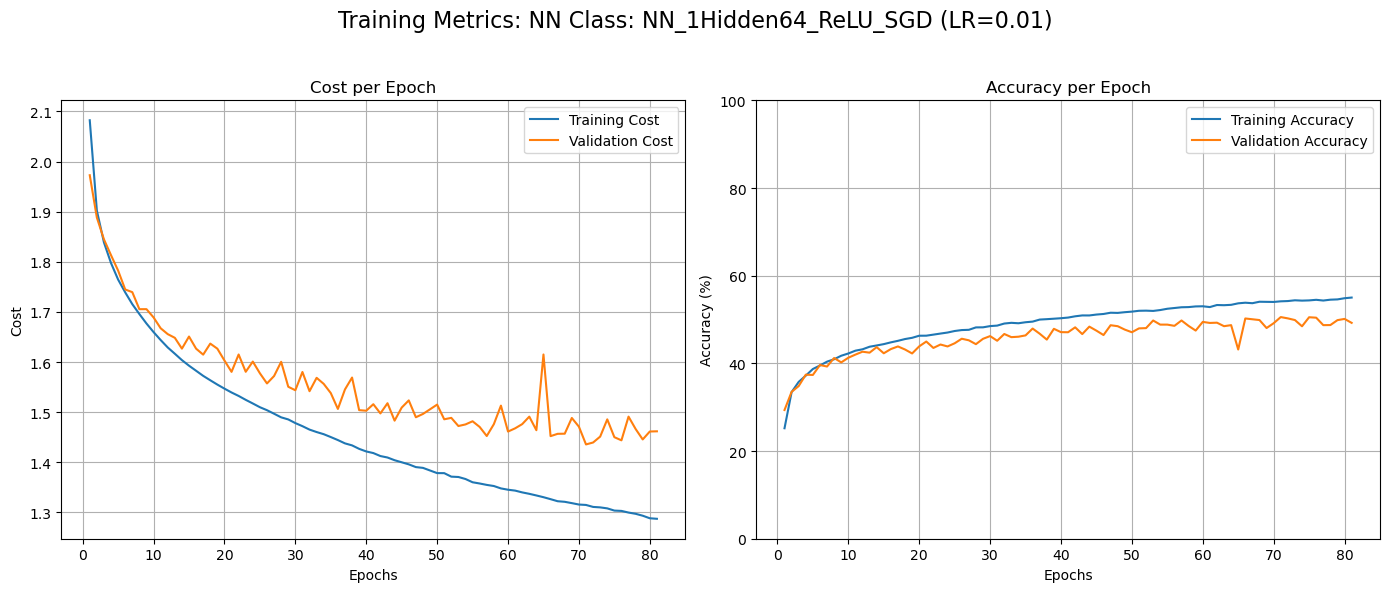


======================================== Running Experiment: NN_1Hidden64_ReLU_Momentum ========================================
Parameters initialized for 2 weighted layers.

--- Starting Training with NeuralNetwork Class ---
Layers: [3072, 64, 10], Hidden Activations: ['relu']
Optimizer: {'name': 'momentum', 'beta': 0.9}, LR: 0.01, Batch Size: 128, Epochs: 1000, Patience: 10
----------------------------------------
Epoch 10/1000 - Train Cost: 1.6612, Train Acc: 42.25% - Val Cost: 1.6828, Val Acc: 41.62%
Epoch 20/1000 - Train Cost: 1.5469, Train Acc: 46.28% - Val Cost: 1.5828, Val Acc: 45.22%
Epoch 30/1000 - Train Cost: 1.4783, Train Acc: 48.56% - Val Cost: 1.5495, Val Acc: 45.98%
Epoch 40/1000 - Train Cost: 1.4260, Train Acc: 50.18% - Val Cost: 1.4990, Val Acc: 48.06%
Epoch 50/1000 - Train Cost: 1.3812, Train Acc: 51.98% - Val Cost: 1.4736, Val Acc: 49.26%
Epoch 60/1000 - Train Cost: 1.3442, Train Acc: 53.00% - Val Cost: 1.4511, Val Acc: 50.36%
Epoch 70/1000 - Train Cost: 1.3150, Tr

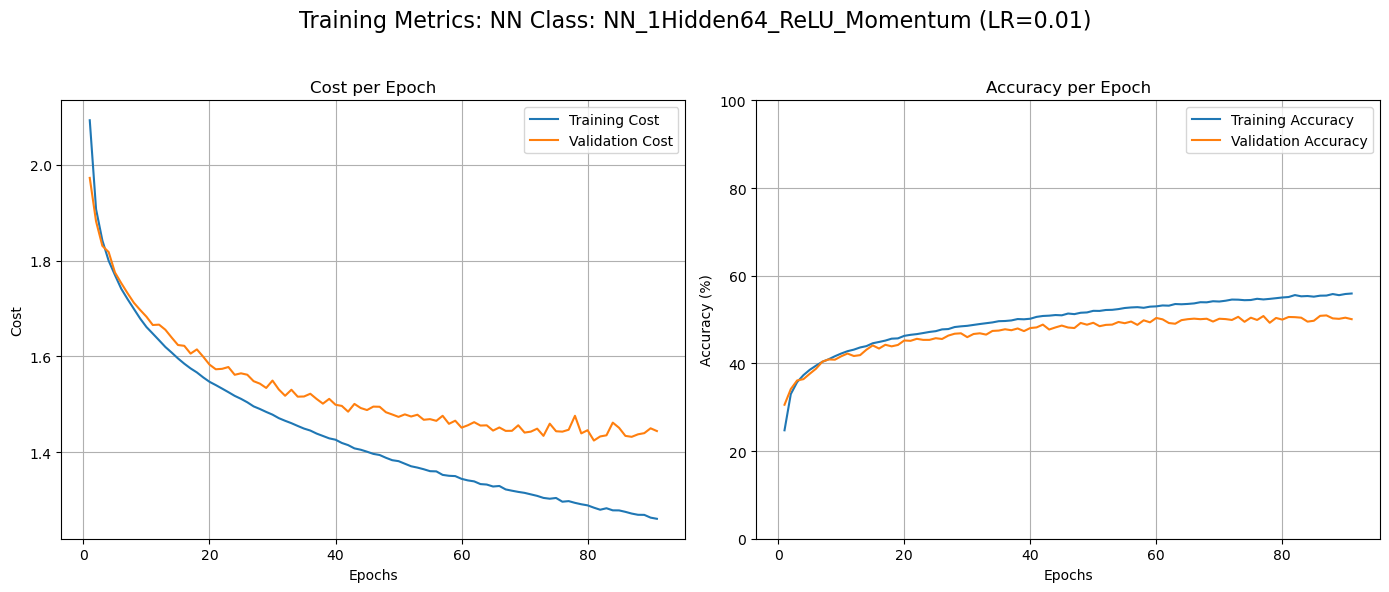


======================================== Running Experiment: NN_1Hidden64_ReLU_Adam ========================================
Parameters initialized for 2 weighted layers.

--- Starting Training with NeuralNetwork Class ---
Layers: [3072, 64, 10], Hidden Activations: ['relu']
Optimizer: {'name': 'adam', 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}, LR: 0.001, Batch Size: 128, Epochs: 1000, Patience: 10
----------------------------------------
Epoch 10/1000 - Train Cost: 1.6370, Train Acc: 42.31% - Val Cost: 1.6495, Val Acc: 42.76%
Epoch 20/1000 - Train Cost: 1.5687, Train Acc: 44.32% - Val Cost: 1.6187, Val Acc: 42.70%
Epoch 30/1000 - Train Cost: 1.5290, Train Acc: 45.67% - Val Cost: 1.5879, Val Acc: 44.34%
Epoch 40/1000 - Train Cost: 1.5112, Train Acc: 46.32% - Val Cost: 1.6092, Val Acc: 43.88%
Early stopping triggered at epoch 48. Best validation cost: 1.5777

--- Final Performance: NN_1Hidden64_ReLU_Adam ---

Classification Report (Test Data):
              precision    recall  f

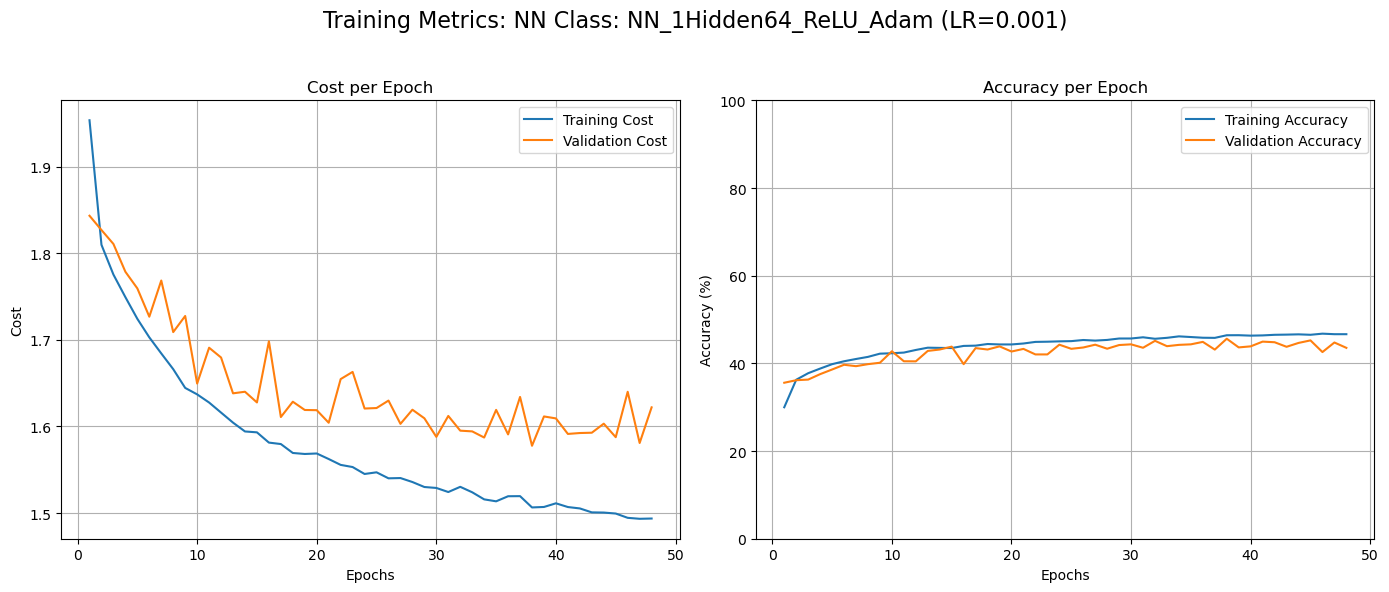


======================================== Running Experiment: NN_2Hidden_128_64_ReLU_Adam ========================================
Parameters initialized for 3 weighted layers.

--- Starting Training with NeuralNetwork Class ---
Layers: [3072, 128, 64, 10], Hidden Activations: ['relu', 'relu']
Optimizer: {'name': 'adam', 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}, LR: 0.001, Batch Size: 128, Epochs: 1000, Patience: 10
----------------------------------------
Epoch 10/1000 - Train Cost: 1.4588, Train Acc: 48.23% - Val Cost: 1.5211, Val Acc: 47.26%
Epoch 20/1000 - Train Cost: 1.3354, Train Acc: 52.70% - Val Cost: 1.4451, Val Acc: 49.56%
Epoch 30/1000 - Train Cost: 1.2723, Train Acc: 55.01% - Val Cost: 1.4532, Val Acc: 49.54%
Epoch 40/1000 - Train Cost: 1.2164, Train Acc: 56.82% - Val Cost: 1.4364, Val Acc: 49.92%
Early stopping triggered at epoch 49. Best validation cost: 1.4201

--- Final Performance: NN_2Hidden_128_64_ReLU_Adam ---

Classification Report (Test Data):
             

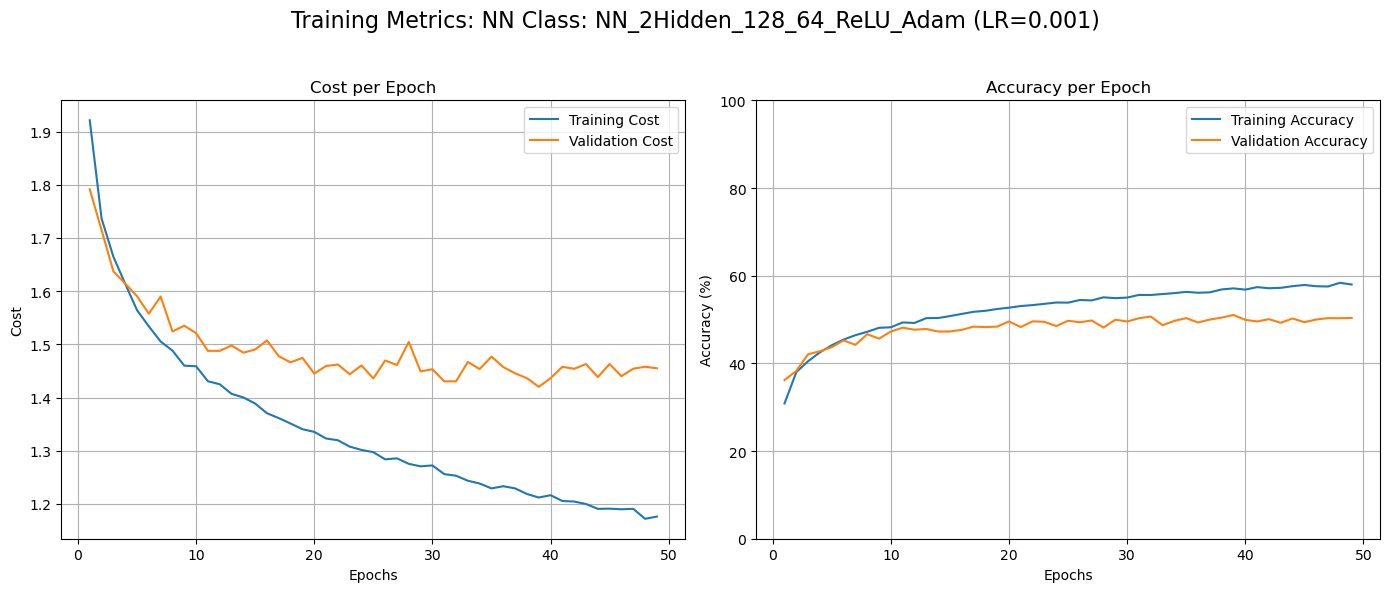


======================================== Running Experiment: NN_1Hidden64_Sigmoid_Adam ========================================
Parameters initialized for 2 weighted layers.

--- Starting Training with NeuralNetwork Class ---
Layers: [3072, 64, 10], Hidden Activations: ['sigmoid']
Optimizer: {'name': 'adam', 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}, LR: 0.001, Batch Size: 128, Epochs: 1000, Patience: 10
----------------------------------------
Epoch 10/1000 - Train Cost: 1.5042, Train Acc: 47.04% - Val Cost: 1.5534, Val Acc: 46.02%
Epoch 20/1000 - Train Cost: 1.3827, Train Acc: 51.42% - Val Cost: 1.4841, Val Acc: 47.28%
Epoch 30/1000 - Train Cost: 1.3049, Train Acc: 54.23% - Val Cost: 1.4619, Val Acc: 48.54%
Epoch 40/1000 - Train Cost: 1.2453, Train Acc: 56.10% - Val Cost: 1.4846, Val Acc: 48.52%
Early stopping triggered at epoch 43. Best validation cost: 1.4362

--- Final Performance: NN_1Hidden64_Sigmoid_Adam ---

Classification Report (Test Data):
              precision    

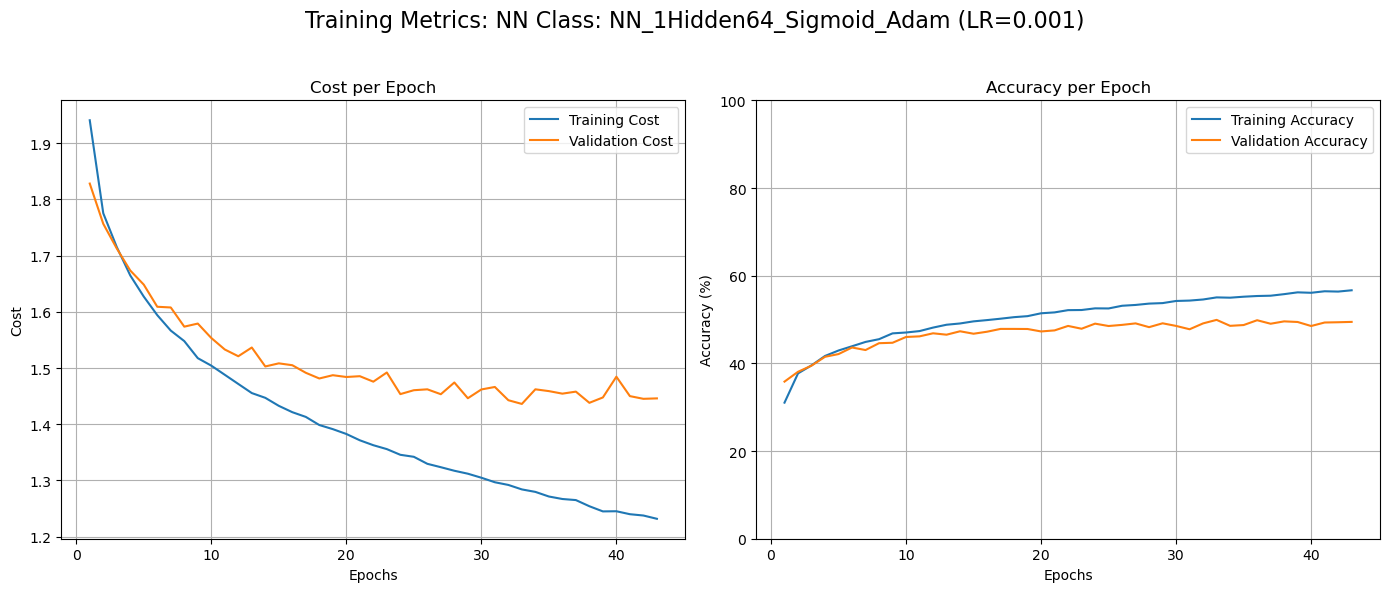



Final Summary of All Experiments:
- NN_1Hidden64_ReLU_SGD: Test Accuracy = 49.37% (Epochs Run: 81)
- NN_1Hidden64_ReLU_Momentum: Test Accuracy = 49.46% (Epochs Run: 91)
- NN_1Hidden64_ReLU_Adam: Test Accuracy = 44.96% (Epochs Run: 48)
- NN_2Hidden_128_64_ReLU_Adam: Test Accuracy = 50.45% (Epochs Run: 49)
- NN_1Hidden64_Sigmoid_Adam: Test Accuracy = 48.31% (Epochs Run: 43)


In [15]:
if __name__ == "__main__":
    # Load and prepare data
    (x_train, y_train_oh, y_train_int,
     x_val, y_val_oh, y_val_int,
     x_test, y_test_int) = load_and_prepare_data_for_nn_class(
        validation_split_ratio=0.1,
        train_subset_size=50000,
        test_subset_size=10000
    )

    # Define common training hyperparameters
    base_training_params = {
        "num_epochs": 1000,
        "minibatch_size": 128,
        "patience_early_stopping": 10,
        "print_cost_every_n_epochs": 10
    }

    # Define experiments
    experiments_to_run = [
        {
            "name": "NN_1Hidden64_ReLU_SGD",
            "layer_dimensions": [x_train.shape[1], 64, 10],  # Corrected from arch_layers
            "hidden_activations": ["relu"],
            "optimizer_config": {"name": "sgd"},
            "learning_rate": 0.01
        },
        {
            "name": "NN_1Hidden64_ReLU_Momentum",
            "layer_dimensions": [x_train.shape[1], 64, 10],  # Corrected from arch_layers
            "hidden_activations": ["relu"],
            "optimizer_config": {"name": "momentum", "beta": 0.9},
            "learning_rate": 0.01
        },
        {
            "name": "NN_1Hidden64_ReLU_Adam",
            "layer_dimensions": [x_train.shape[1], 64, 10],  # Corrected from arch_layers
            "hidden_activations": ["relu"],
            "optimizer_config": {"name": "adam", "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8},
            "learning_rate": 0.001
        },
        {
            "name": "NN_2Hidden_128_64_ReLU_Adam",
            "layer_dimensions": [x_train.shape[1], 128, 64, 10],  # Corrected from arch_layers
            "hidden_activations": ["relu", "relu"],
            "optimizer_config": {"name": "adam", "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8},
            "learning_rate": 0.001
        },
        {
            "name": "NN_1Hidden64_Sigmoid_Adam",
            "layer_dimensions": [x_train.shape[1], 64, 10],  # Corrected from arch_layers
            "hidden_activations": ["sigmoid"],
            "optimizer_config": {"name": "adam", "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8},
            "learning_rate": 0.001
        }
    ]

    all_results_summary = {}

    for experiment_config in experiments_to_run:
        print("\n" + "=" * 40 + f" Running Experiment: {experiment_config['name']} " + "=" * 40)

        model = NeuralNetwork(
            layer_dimensions=experiment_config["layer_dimensions"],  # Corrected keyword
            hidden_activations=experiment_config["hidden_activations"]
        )

        current_run_params = base_training_params.copy()
        current_run_params["learning_rate"] = experiment_config["learning_rate"]

        training_history = model.train(
            x_train, y_train_oh, y_train_int,
            x_val, y_val_oh, y_val_int,
            optimizer_config=experiment_config["optimizer_config"],
            **current_run_params,
            adam_iteration_init=1
        )

        final_test_accuracy = model.evaluate(x_test, y_test_int, model_name_for_report=experiment_config["name"])
        plot_training_metrics(training_history,
                              model_name_title=f"NN Class: {experiment_config['name']} (LR={experiment_config['learning_rate']})")

        all_results_summary[experiment_config["name"]] = {
            "test_accuracy": final_test_accuracy,
            "epochs_run": training_history["epochs_run"],
            "config_details": experiment_config
        }

    print("\n\n" + "===" * 25)
    print("Final Summary of All Experiments:")
    for model_name, result_data in all_results_summary.items():
        print(f"- {model_name}: Test Accuracy = {result_data['test_accuracy']:.2f}% "
              f"(Epochs Run: {result_data['epochs_run']})")
    print("===" * 25)